# Density matrices in Fock space

In this notebook we introduce our new feature: __density matrices__ in __fock space__. This space is a mathematical framework to describe the quantum states of a system with variable number of particles, __photons__ in our case. Note that this space is much larger than the computational/logical space. Fock space is native to _Perceval_ and hence these matrices can be indispensable for linear optic computations.

The difference in the basis is demonstrated in the following example of 1-qubit X gate. In logical space, the basic states of the system will be $|0\rangle$, and $|1\rangle$. The linear optical circuit implementation for this gate consists of a 2 mode circuit with the following basic states in the fock space - $|00\rangle$, $|10\rangle$, $|01\rangle$, and, $|11\rangle$.

We will demonstrate how to create density matrices in _Perceval_ and the different methods can be applied on them for computation using @ simple examples - Bell State generation and Hong-Ou_Mandel effect.


In [1]:
import perceval as pcvl
import numpy as np
from perceval.components import BS, Source, Circuit, catalog
from perceval.utils import BasicState, DensityMatrix
from perceval import Simulator
from perceval.backends import SLOSBackend

## I. Generating and Evolving a Bell State density matrix

 In _Perceval_, a density matrix is created by simply converting from the corresponding BasicState or StateVector Distribution.

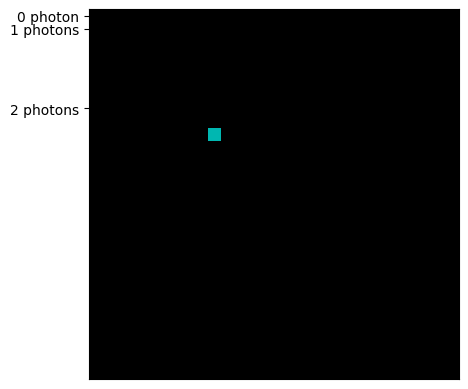

In [2]:
input_dm = DensityMatrix.from_svd(BasicState([1,0,1,0,0,0]))
pcvl.pdisplay(input_dm)

The next step in applying the evolution operator is to define the LO circuit corresponding to the operation. Here, it is demonstrated by a Linear Optical circuit consisting of a Hadamard gate and a post-processed CNOT gate used for Bell State generation.

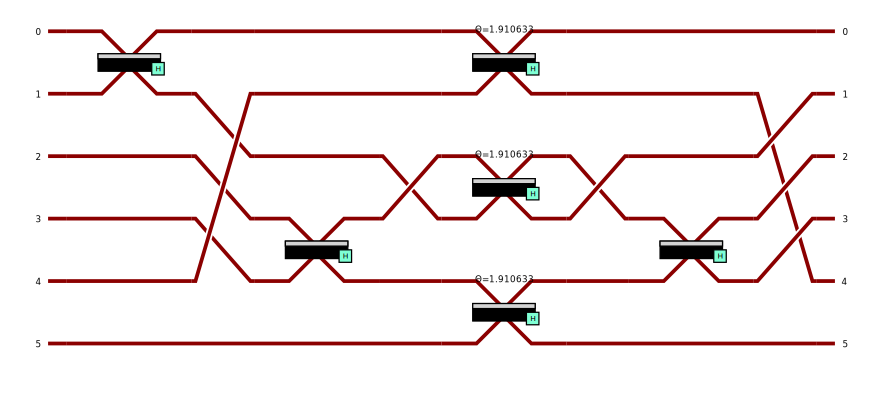

In [4]:
bell_circ = Circuit(m=6)

bell_circ.add(0, BS.H())
bell_circ.add(0, catalog['postprocessed cnot'].build_circuit(), merge=True)
pcvl.pdisplay(bell_circ)

To perform the computation on the input density matrix, a simulator is constructed with the circuit  and the necessary post-selection function.

Output Density matrix - Bell State


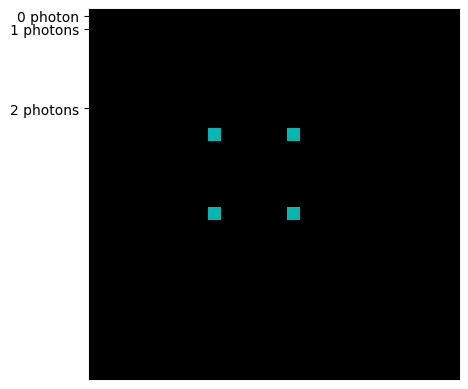

In [4]:
cnot = catalog['postprocessed cnot'].build_processor()  # creating a postprocessed cnot from catalog for the heralding and the post-selection function

bell_simulator = Simulator(SLOSBackend())
bell_simulator.set_circuit(bell_circ)
bell_simulator.set_selection(heralds=cnot.heralds, postselect=cnot.post_select_fn)

# Applying the evolution
bell_out_dm = bell_simulator.evolve_density_matrix(input_dm)  # apply evolution on the density matrix
print('Output Density matrix - Bell State')
pcvl.pdisplay(bell_out_dm)

This output density matrix corresponds identically to evolving a statevector through the circuit and then converting the output SVD into a density matrix.

The output statevector distribution: sqrt(2)/2*|1,0,1,0,0,0>+sqrt(2)/2*|0,1,0,1,0,0>
The density matrix converted from the output SVD


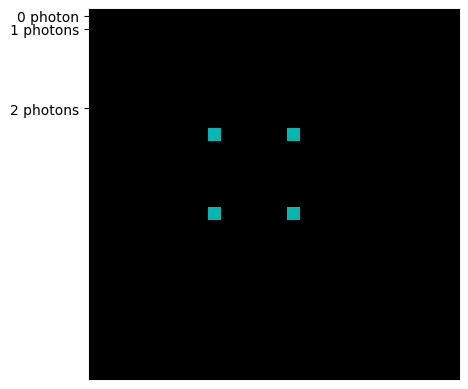

In [5]:
output_svd = bell_simulator.evolve(BasicState([1,0,1,0,0,0]))
print('The output statevector distribution:', output_svd)

print('The density matrix converted from the output SVD')
pcvl.pdisplay(DensityMatrix.from_svd(output_svd))

## II. Investigating the Hong-Ou-Mandel effect using Density Matrix

For this we create a simulator with a 2 mode circuit consisting of a beam splitter. The output density matrix demonstrates quantum coherence through the non-zero off-diagonal coefficients.

output density matrix without any loss


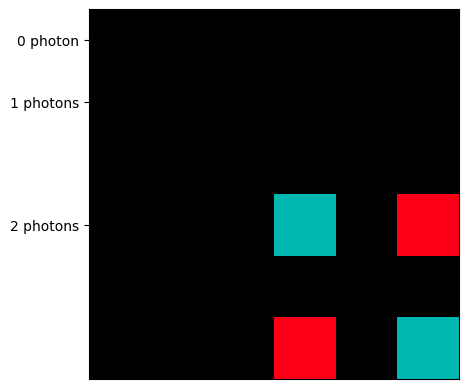

In [6]:
sim = Simulator(SLOSBackend())
sim.set_circuit(BS.H())

# generate input density matrix
source = Source()  # perfect source
input_density_matrix = DensityMatrix.from_svd(source.generate_distribution(BasicState([1, 1])))

# evolution of density matrix
output_density_matrix = sim.evolve_density_matrix(input_density_matrix)
print('output density matrix without any loss')
pcvl.pdisplay(output_density_matrix)

### Apply a Loss operator on density matrix

The density matrices allow for application of a loss operator by defining the modes on which photons are lost and the probability of loss. The application of the loss operator and its effect are illustrated below using a simple 2 mode LO circuit with a beam splitter and a noisy source with emission probability of 0.6. Computationally, this is equivalent to a perfect source with a probability of 0.4 for loosing a photon at each input mode before the circuit.


output density matrix with loss


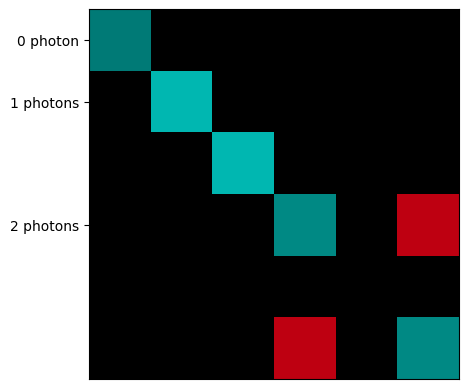

In [7]:
input_density_matrix.apply_loss([0, 1], 0.4)  # this loss operator is equivalent to 0.6 emission probability from source

lossy_output_density_matrix = sim.evolve_density_matrix(input_density_matrix)  # evolving this lossy density matrix
print('output density matrix with loss')
pcvl.pdisplay(lossy_output_density_matrix)

### Computing the expectation value of an operator

The expectation value of an operator $\hat{O}$ over a quantum system represented by a density matrix $\rho$ is given by the nice formula :

$$ \langle\hat{O}\rangle = Tr (\hat{O}\rho) $$

In the next cell, we evaluate the expectation value of the number operator $\hat{N}$ using the previous lossy density matrix generated by evolving through the beamsplitter.

In [8]:
dm_shape = lossy_output_density_matrix.shape

# Constructing the number operator
number_operator = np.zeros(dm_shape)
for state, index in lossy_output_density_matrix.index.items():
    number_operator[index, index] = state.n

expectation_value = (number_operator @ lossy_output_density_matrix.mat).trace()
print('The expectation value obtained (expected, there is a 60% chance of photons passing through the circuit):', expectation_value)


The expectation value obtained (expected, there is a 60% chance of photons passing through the circuit): (1.2000000000000004+0j)


## III. Performing measurements on density matrix

A measurement on density matrix in _Perceval_ is performed by defining the modes to be measured. The process returns a dictionary with the measured states as keys with values - probability of measuring the corresponding state and remaining density matrix. In T=the following cell, measurements on the output density matrix after the beam splitter (above) is demonstrated.

In [9]:
print('The output density matrix', output_density_matrix)

res = output_density_matrix.measure([0])  # performing measurements define the modes to measure
for keys, values in res.items():
    measured_state = keys
    prob_meas = values[0]
    remaining_dm = values[1]
    print('state measured:', measured_state, 'with probability', prob_meas, 'and the remaining density matrix', remaining_dm)

The output density matrix 0.50+0.00j*|2,0><2,0|+-0.50+0.00j*|0,2><2,0|+-0.50+0.00j*|2,0><0,2|+0.50+0.00j*|0,2><0,2|
state measured: |0> with probability 0.5000000000000001 and the remaining density matrix 1.00+0.00j*|2><2|
state measured: |2> with probability 0.5000000000000001 and the remaining density matrix 1.00+0.00j*|0><0|


Let's see the difference if this measurement was performed on the lossy case

In [10]:
print('The lossy output density matrix', lossy_output_density_matrix)

lossy_res = lossy_output_density_matrix.measure([0])  # choose modes to measure
for keys, values in lossy_res.items():
    print('state measured:', keys, 'with probability', values[0])  # key: measured basic state, values[0]: probability of measuring the state

The lossy output density matrix 0.16+0.00j*|0,0><0,0|+0.24+0.00j*|1,0><1,0|+0.00+0.00j*|0,1><1,0|+0.00+0.00j*|1,0><0,1|+0.24+0.00j*|0,1><0,1|+0.18+0.00j*|2,0><2,0|+-0.18+0.00j*|0,2><2,0|+-0.18+0.00j*|2,0><0,2|+0.18+0.00j*|0,2><0,2|
state measured: |0> with probability 0.5800000000000002
state measured: |1> with probability 0.24000000000000005
state measured: |2> with probability 0.18000000000000008
